# Community alignment of training questions

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## Question sample

In [2]:
from load_forecasted_open_questions import load_forecasted_open_questions

In [3]:
num_questions = (0,100000)

In [4]:
questions = load_forecasted_open_questions(num_questions)

2025-06-16 14:18:59.663 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [5]:
questions_binary = [question for question in questions if question.api_json['question']['type'] == 'binary']

In [6]:
questions_multiple_choice = [question for question in questions if question.api_json['question']['type'] == 'multiple_choice']

In [7]:
questions_numeric = [question for question in questions if question.api_json['question']['type'] == 'numeric']

In [8]:
[len(x) for x in [questions_binary, questions_multiple_choice, questions_numeric]]

[699, 24, 136]

## Community forecast

In [9]:
from community_forecast import *

In [10]:
id_to_forecast = {question.api_json['id']: community_forecast(question) for question in questions}

In [11]:
id_to_question = {question.api_json['id']: question for question in questions}

## 000 forecast

In [12]:
import glob
fns = glob.glob('forecast_community/*.md')

In [13]:
type(questions_numeric[0])

forecasting_tools.data_models.questions.NumericQuestion

In [14]:
fn = fns[0]

In [15]:
ids = [int(fn.split('/')[1].split('.')[0]) for fn in fns]

In [16]:
forecasts = {id: open(f'forecast_community/{id}.md').read() for id in ids}

In [17]:
community_ids = list(id_to_forecast.keys())

In [18]:
type(community_ids[0])

int

In [19]:
forecast_ids = list(forecasts.keys())

In [20]:
done = list(set(forecast_ids).intersection(community_ids))

In [21]:
from extract_forecast import *

def extract_only_forecast(id):
    question = id_to_question[id]
    question_type = type(question)
    forecast = forecasts[id]
    if question_type == forecasting_tools.data_models.questions.BinaryQuestion:
        prediction = extract_probability_from_response_as_percentage_not_decimal(forecast)/100.0
    elif question_type == forecasting_tools.data_models.questions.MultipleChoiceQuestion:
        options = question.options
        option_probabilities = extract_option_probabilities_from_response(forecast, options)
        prediction = generate_multiple_choice_forecast(options, option_probabilities)
    elif question_type == forecasting_tools.data_models.questions.NumericQuestion:
        prediction = extract_percentiles_from_response(forecast)
    return prediction

In [22]:
import forecasting_tools

In [23]:
for id in done:
    try:
        foo = extract_only_forecast(id)
    except:
        print(f'rm forecast_community/{id}.md')

In [25]:
predictions = {id: extract_only_forecast(id) for id in done}

## Put this in a dataframe

In [105]:
from flatten_dict import flatten_dict
import pandas as pd
from prompt_question import prompt_question
pd.set_option('display.max_columns', None)

In [106]:
q_done = [id_to_question[id] for id in done]

In [107]:
qflat = [flatten_dict(q.api_json, sep='_') for q in q_done]

In [108]:
df = pd.DataFrame(qflat)

In [109]:
df.iloc[26]

id                                                                                                 4219
title                                                 Will large scale solar radiation management be...
short_title                                                                                            
url_title                                                                                              
slug                                                  will-large-scale-solar-radiation-management-be...
                                                                            ...                        
question_my_forecasts_latest_centers                                                                NaN
question_my_forecasts_latest_interval_upper_bounds                                                  NaN
question_my_forecasts_latest_distribution_input                                                     NaN
html_metadata_json_title                                        

In [110]:
df['crowd'] = df.apply(lambda row: id_to_forecast[row.id], axis=1)

In [111]:
def pull_asknews(row):
    fn = f'asknews/{row.id}.md'
    with open(fn, 'r') as f:
        return f.read()

In [112]:
df['question_options'] = df['question_options'].apply(repr)

In [113]:
df = df[['id',
 'open_time',
 'scheduled_resolve_time',
 'title',
 'question_description',
 'question_resolution_criteria',
 'question_fine_print',
 'question_type',
 'question_options',
 'question_group_variable',
 'question_question_weight',
 'question_unit',
 'question_open_upper_bound',
 'question_open_lower_bound',
 'question_scaling_range_max',
 'question_scaling_range_min',
 'question_scaling_zero_point',
 'crowd']]

In [114]:
from datetime import datetime
dfn = 'forecast_community'
df['today'] = datetime.now().strftime("%Y-%m-%d")

In [115]:
df['asknews'] = df.apply(pull_asknews, axis=1)

In [116]:
df.columns

Index(['id', 'open_time', 'scheduled_resolve_time', 'title',
       'question_description', 'question_resolution_criteria',
       'question_fine_print', 'question_type', 'question_options',
       'question_group_variable', 'question_question_weight', 'question_unit',
       'question_open_upper_bound', 'question_open_lower_bound',
       'question_scaling_range_max', 'question_scaling_range_min',
       'question_scaling_zero_point', 'crowd', 'today', 'asknews'],
      dtype='object')

In [117]:
def load_research(row):
    with open(f"research/{row['id']}.md", 'r') as f:
        return f.read()

df['research'] = df.apply(load_research, axis=1)

In [118]:
df['asknews']

0      Here are the relevant news articles:\n\n**Huma...
1      Here are the relevant news articles:\n\n**Iran...
2      Here are the relevant news articles:\n\n**EU P...
3      Here are the relevant news articles:\n\n**UK D...
4      Here are the relevant news articles:\n\n**US D...
                             ...                        
706    Here are the relevant news articles:\n\n**Bitc...
707    Here are the relevant news articles:\n\n**Bitc...
708    Here are the relevant news articles:\n\n**EU E...
709    Here are the relevant news articles:\n\n**Chat...
710    Here are the relevant news articles:\n\n**Stud...
Name: asknews, Length: 711, dtype: object

In [119]:
from RAGForecaster import RAGForecaster
from EnhancedResearchPro import EnhancedResearchPro

In [120]:
    rag = RAGForecaster()

Loaded existing index from forecast_index.faiss
Index contains 4766 vectors at initialization


In [121]:
    research_bot = EnhancedResearchPro(rag)

In [122]:
df['id_of_question'] = df['id']

In [123]:
    research_bot.process_dataframe(df, use_cutoff=False)

In [124]:
    rag.research_bot = research_bot

    # Updated learning field with raw text extraction
    df['learning'] = df.apply(
        lambda row: [
            m['raw_text'] 
            for m, _ in research_bot.retrieval_cache.get(row['title'], []) 
            if 'raw_text' in m  # Safety check for legacy entries
        ], 
        axis=1
    )


In [125]:
df['prompt'] = df.apply(prompt_question, axis=1)

In [126]:
from tqdm import tqdm
tqdm.pandas()

In [127]:

def predict(dfn, question, iterations = 3):
    ffn = f'{dfn}/{question.id_of_question}.md'
    with open(ffn, 'r') as f:
        return f.read()


In [128]:
df['forecast'] = df.progress_apply(lambda question: predict(dfn, question), axis=1)

100%|██████████████████████████████████████| 711/711 [00:00<00:00, 33690.52it/s]


In [ ]:
from extract_forecast import extract_forecast

df['prediction'] = df.apply(extract_forecast, axis=1)

## Compare

In [130]:
from error import error

In [ ]:
df = df[~df.crowd.apply(lambda x: x is None)].copy()

df['error'] = df.apply(error, axis=1)

In [132]:
df.head(3)

,id,open_time,scheduled_resolve_time,title,question_description,question_resolution_criteria,question_fine_print,question_type,question_options,question_group_variable,question_question_weight,question_unit,question_open_upper_bound,question_open_lower_bound,question_scaling_range_max,question_scaling_range_min,question_scaling_zero_point,crowd,today,asknews,research,id_of_question,learning,prompt,forecast,prediction,error
0,10243,2022-03-16T04:00:00Z,3001-01-01T04:59:00Z,"If humanity goes extinct, will another intelli...","In a blog post, Paul Christiano argues that we...","For the purpose of this question, what it mean...",,binary,None,,1.0,,None,None,NaN,NaN,NaN,0.4,2025-06-16,Here are the relevant news articles:\n\n**Huma...,## Key Historical Trends and Current Status\n\...,10243,[],You are a professional forecaster interviewing...,Here is a combined rationale that incorporates...,0.7,0.30
1,10244,2022-08-14T07:00:00Z,2041-01-01T05:00:00Z,Will Iran possess a nuclear weapon before 2041?,A [previous Metaculus question](https://www.me...,This question will resolve as **Yes** if the I...,,binary,None,,1.0,,None,None,NaN,NaN,NaN,0.69,2025-06-16,Here are the relevant news articles:\n\n**Iran...,## 1. Key Historical Trends and Current Status...,10244,[],You are a professional forecaster interviewing...,Here is the combined rationale that incorporat...,0.2,0.49
2,28682,2024-10-01T16:56:00Z,2030-01-01T17:00:00Z,Will any country trigger article 50 to leave t...,This forecasting question is associated with t...,"The question will resolve as **Yes** if, befor...",The completion of the withdrawal process is no...,binary,None,,1.0,,False,False,NaN,NaN,NaN,0.11,2025-06-16,Here are the relevant news articles:\n\n**EU P...,1. **Key Historical Trends and Current Status*...,28682,[],You are a professional forecaster interviewing...,Here is a combined rationale that incorporates...,0.6,0.49


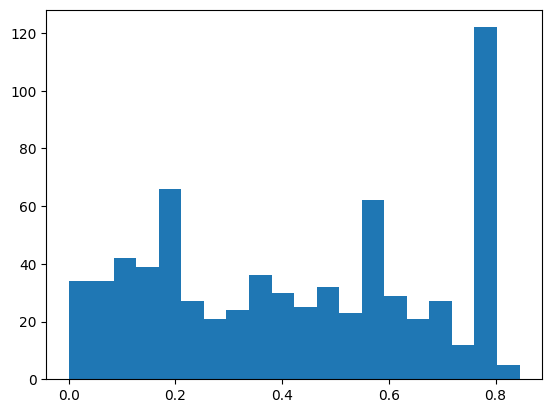

In [135]:
plt.hist(df.error.values, bins=20);

In [136]:
df.to_json('community_local_results.json', indent=4)

In [137]:
df1 = df[['title', 'question_type', 'prediction', 'crowd', 'error']]
df1.head(30)

,title,question_type,prediction,crowd,error
0,"If humanity goes extinct, will another intelli...",binary,0.7,0.4,0.300000
1,Will Iran possess a nuclear weapon before 2041?,binary,0.2,0.69,0.490000
2,Will any country trigger article 50 to leave t...,binary,0.6,0.11,0.490000
3,"If China invades Taiwan before 2035, will the ...",binary,0.3,0.25,0.050000
4,Will the Chinese Yuan be among the top 3 globa...,binary,0.4,0.37,0.030000
5,Will there be a positive transition to a world...,binary,0.8,0.53,0.270000
6,Will the size of the US Supreme Court increase...,binary,0.01,0.05,0.040000
7,"After a weak AGI is created, how many months w...",numeric,"[0.05, 0.050050000000000004, 0.050100000000000...","{10: 13.221944759886265, 20: 16.50158147430704...",0.800000
8,Will TikTok still be available in the United S...,multiple_choice,"{'Yes, still owned by foreign adversary': 0.33...","{'Yes, still owned by foreign adversary': 0.47...",0.355728
9,Will the USA enter a second civil war before 2...,binary,0.2,0.04,0.160000


In [138]:
df1.to_csv('community_local.csv')

In [140]:
!ls *.json

community_local_results.json  questions.json	      run_with_predictions.json
community_results.json	      rag_system_report.json  scored.json
debug.json		      resolved.json	      wow.json


In [147]:
dfp = pd.read_csv('comm_perp.csv')

In [148]:
dfp.head(3)

,Unnamed: 0,title,question_type,prediction,crowd,error
0,0,"If humanity goes extinct, will another intelli...",binary,0.25,0.4,0.15
1,1,Will Iran possess a nuclear weapon before 2041?,binary,0.4,0.69,0.29
2,2,Will any country trigger article 50 to leave t...,binary,0.12,0.11,0.01


In [146]:
dfp.error.values

array([1.e+10])

In [149]:
df.error.mean()

0.42895934890238163

In [150]:
dfp.error.mean()

0.2798393752964097

In [152]:
df.error.std()

0.26066897413420154

In [153]:
dfp.error.std()

0.2822323998781548

In [154]:
len(dfp), len(df)

(711, 711)